# Imports and loading dataset
#### FinBert labelled tweets dataset
Since labelling tweets with price changes results in a low accuracy, we have decided to use a pretrained financial sentiment analysis model to label these tweets, and then training our own model with these labels. The models we have used to label the tweets is the [ProsusAI/FinBert model](https://huggingface.co/ProsusAI/finbert) from `huggingface`
<br>
The dataset contains our tweets with a `bullish` label that is either 'positive', 'neutral' or 'negative', labelled using the above model

In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import numpy as np

from wordcloud import WordCloud

df = pd.read_csv("../input/financial-tweets-and-stock-prices/finbert_labelled_tweets.csv")
df

,date,symbol,tweet,id,bullish
0,2021-05-17,GM,we closed this $gm position for a 37% #profit 👍,NaN,neutral
1,2021-05-17,GM,$gm dfly. let’s get it !#greenteam,NaN,neutral
2,2021-05-17,UAL,united airlines ( $ual ) will add more than 40...,NaN,positive
3,2021-05-17,UAL,"united adding 400+ daily flights in july, says...",NaN,negative
4,2021-05-17,UAL,#unitedairlines adds more flights on rising #t...,NaN,neutral
...,...,...,...,...,...
25896,2021-06-15,WISH,$wish great open!,1.404794e+18,neutral
25897,2021-06-15,WISH,$wish,1.404794e+18,neutral
25898,2021-06-16,FB,$fb set to begin testing ads inside oculus vir...,1.405242e+18,neutral
25899,2021-06-16,GM,why says general motors ( $gm ) is a 'winner' 👀,1.405209e+18,neutral


Again, let's define some utility functions for visualisations

In [2]:
# Print 5 sample tweets from the dataframe, along with its associated symbol
# and the link to the original tweet if the id exists
def print_tweets(df):
    sample = df.sample(n=5, random_state=43)
    for _, row in sample.iterrows():
        print(f"Symbol: {row.symbol}")
        if type(row.id) == str:
            print(f"Link: https://twitter.com/user/status/{row.id}")
        print(f"Text: {row.tweet}")
        print("==============================")

In [3]:
def get_wordcloud(df):
    text_data = " ".join(text for text in df['tweet'])
    wordcloud = WordCloud(max_font_size=50, background_color="white").generate(text_data)
    return wordcloud

### Visualisation of labelled tweets
Since the finBert model categories each tweet into one of three categories, let's try to see if there are any distinct differences between the groups

In [4]:
bullish_tweets = df.loc[df.bullish == 'positive']
neutral_tweets = df.loc[df.bullish == 'neutral']
bearish_tweets = df.loc[df.bullish == 'negative']

#### Bullish tweets

In [5]:
print_tweets(bullish_tweets)

Symbol: OPGN
Text: $opgn opgen submits updated 510(k) summary to fda and successfully completes move to new headquarters in maryland
Symbol: FTEK
Text: $ftek out of the 890 other times ftek was up 3.5% during a trading day, 60% of the time it traded lower by the next day's market close. ://
Symbol: MU
Text: $mu [may-28 80.00 puts] option volume up +452.78% | volume: 199 vs 36|
Symbol: BP
Text: $bp showing up in our top breakout selection.
Symbol: PTON
Text: thanks for sharing soumya. interesting seeing how much music fees $pton paid. a pretty significant (and growing) amount for the music industry.


#### Neutral tweets

In [6]:
print_tweets(neutral_tweets)

Symbol: BNGO
Text: the $bngo gorillas with the juiciest update. thanks guys! 🦍🇺🇸🇬🇧🇩🇪🚀
Symbol: MOSY
Text: $mosy awaiting for buy signal on mosy so much easier with the ultraalgo delivering signals in real-time including institutional trades.
Symbol: TME
Text: malaysia's airasia applies for digital banking license $tme
Symbol: RF
Text: $rf 25-nse regions financial (15 jun, 10:46am) 📄 exchange delisting #rf #25nse #regionsfinancial
Symbol: APPS
Text: $apps reclaimed the 50 day yesterday. moving pre-market. solid numbers, est, etc. w/l for now.


#### Bearish tweets

In [7]:
print_tweets(bearish_tweets)

Symbol: PTON
Text: when competitors are selling their bikes at a fraction of $pton's prices in walmart and people still think it's a fad.
Symbol: TEVA
Text: $teva: new insider filing on teva pharmaceutical industries ltd's director perry nisen:
Symbol: SONO
Text: i'm giving $sono another look next week. i just looked and there sold out around me and on back order. could be a negative if they can't fulfill orders but good sign of demand.
Symbol: CAN
Text: $can out of the 189 other times can was down 3.8% during a trading day, 53% of the time it traded lower by the next day's market close. #coinflip ://
Symbol: AZN
Text: $azn above avg volume daily appearances since 2010: 135 close 5 days later ±: avg: -0.04 sd: 1.67 worst: -5.30 best: 6.04 10 days later: avg: 0.01 sd: 2.00 worst: -5.32 best: 6.13 30 days later: avg: 0.15 sd: 2.78 worst: -5.41 best: 9.20


#### Wordclouds of the 3 type of labelled tweets

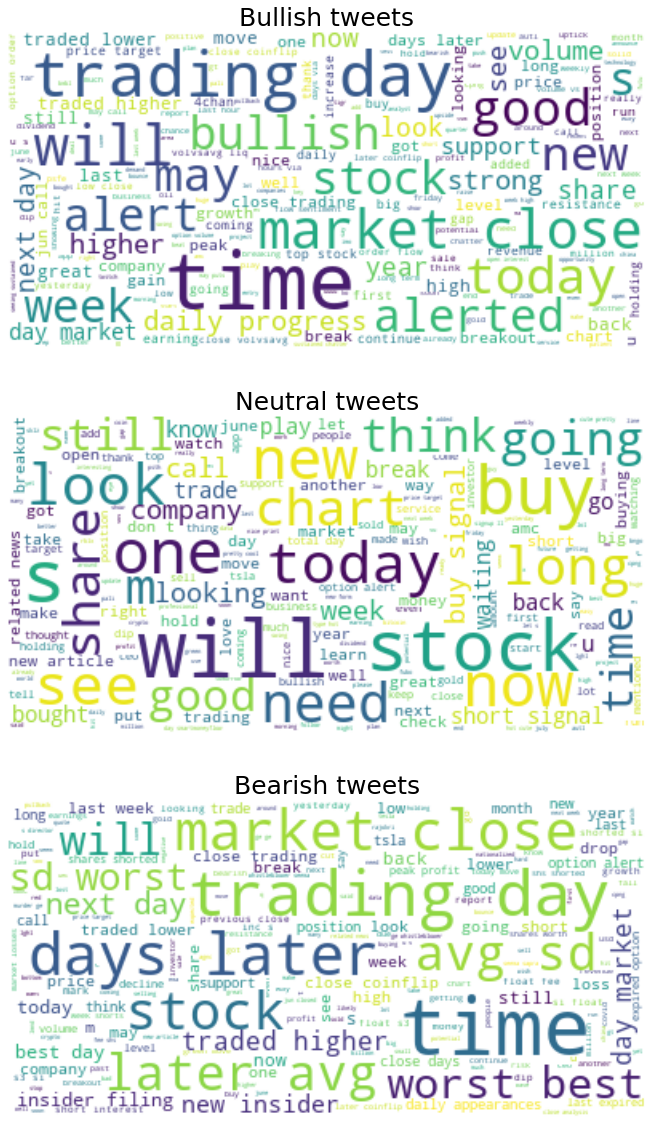

In [8]:
bullish_wordcloud = get_wordcloud(bullish_tweets)
neutral_wordcloud = get_wordcloud(neutral_tweets)
bearish_wordcloud = get_wordcloud(bearish_tweets)

fig, ax = plt.subplots(3, 1, figsize=(20, 20))
ax[0].imshow(bullish_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title("Bullish tweets", fontsize=25)

ax[1].imshow(neutral_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title("Neutral tweets", fontsize=25)

ax[2].imshow(bearish_wordcloud, interpolation='bilinear')
ax[2].axis('off')
ax[2].set_title("Bearish tweets", fontsize=25)
plt.show()

Since these labels are from a finBert trained on a large financial corpus, we can see distinct differences between these wordclouds. There are words like 'bullish' and 'strong' that appear frequently in bullish tweets, while words like 'worst' appearing more in bearish tweets.
<br>
We will try to train a model based on these labels using our previous methods

### Training a tweet classifier
We will first prepare the data for training, mainly by down sampling the data and also splitting them into train test sets.
<br>
The number of samples in our dataset for each class is currently inbalanced, where most of the tweets are labelled as neutral. We will down sample every class to have the same number of samples for the sake of training the classifier.

<AxesSubplot:xlabel='bullish', ylabel='count'>

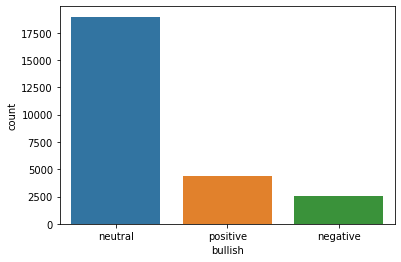

In [9]:
sns.countplot(x='bullish', data=df)

In [10]:
sample_size = min(len(bullish_tweets), len(bearish_tweets), len(neutral_tweets))
print(f"Sample size for each label is: {sample_size}")

# Join equal number of bullish and bearish labelled tweets and reshuffle
df = pd.concat([
    bullish_tweets.sample(n=sample_size, random_state=42),
    bearish_tweets.sample(n=sample_size, random_state=42),
    neutral_tweets.sample(n=sample_size, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

df

Sample size for each label is: 2587


,date,symbol,tweet,id,bullish
0,2021-06-16,AES,$aes puco approves the aes ohio settlement agr...,1.405281e+18,positive
1,2021-06-17,GLW,$glw out of the 360 other times glw was down 1...,1.405394e+18,negative
2,2021-07-02,QS,$qs stock sub 30? this thing takes a 50% drawd...,1.410803e+18,positive
3,2021-06-17,DAL,websites of major u.s. airlines face outage - ...,1.405396e+18,negative
4,2021-05-26,SU,"$su suncor well defined resistance at 30, a br...",1.397404e+18,positive
...,...,...,...,...,...
7756,2021-06-20,BMY,bristol myers pays $650 million for rights to ...,1.406649e+18,neutral
7757,2021-06-12,SNOW,$snow new insider selling: 26821 shares.,1.403576e+18,neutral
7758,2021-06-28,SENS,"$sens is up 8.99% on 145,033 volume. now tradi...",1.409425e+18,positive
7759,2021-06-08,TME,are you long $tme or no?,1.402175e+18,neutral


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['bullish'],
                                                    test_size=0.2, random_state=42)

We will train a LinearSVC model by converting the corpus into a bag of words using a TFIDF Vectorizer
<br>
Again, the model will be optimised by the number of features in its bag of words vectorizer, and we will pick the number of features that gives the highest accuracy

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_svm = vectorizer.fit_transform(X_train)

classifier = LinearSVC(max_iter=5000)
classifier.fit(X_train_svm, y_train)

y_pred = classifier.predict(vectorizer.transform(X_test))
print("Accuracy score: ", accuracy_score(y_test, y_pred) * 100)

Accuracy score:  73.59948486799742


In [13]:
def get_accuracy(num_features):
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=num_features)
    X_train_svm = vectorizer.fit_transform(X_train)
    classifier = LinearSVC(max_iter=5000)
    classifier.fit(X_train_svm, y_train)
    y_pred = classifier.predict(vectorizer.transform(X_test))
    return accuracy_score(y_test, y_pred) * 100

In [14]:
accuracy_against_features = pd.DataFrame(columns = ['num_features', 'accuracy'])
min_features = 70000
max_features = 75000
step = 200
for index, feature in enumerate(range(min_features, max_features, step)):
    accuracy_against_features.loc[index] = [feature, get_accuracy(feature)]

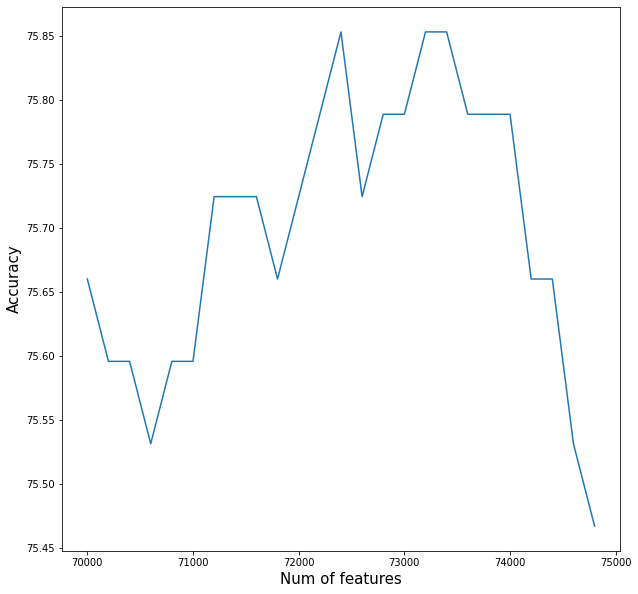

In [15]:
num_features = accuracy_against_features['num_features']
accuracies = accuracy_against_features['accuracy']

plt.figure(figsize=(10, 10))
plt.plot(num_features, accuracies)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("Num of features", fontsize=15)
plt.show()

In [16]:
max_row = accuracy_against_features.loc[accuracies.idxmax()]
print(f"Max accuracy is {max_row.accuracy} with {max_row.num_features} features")

Max accuracy is 75.85318737926595 with 72400.0 features


The model now has a 75% accuracy on a 3 class classification, which is an improvement over our previous model. Although this accuracy is mostly carried over from the pretrained finBert model, this trained model is further trained using twitter data, thus fitting our use case more.

We will keep the model that give the highest accuracy for later use

In [17]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=int(max_row.num_features))
X_train_svm = vectorizer.fit_transform(X_train)

svm_classifier = LinearSVC(max_iter=5000)
svm_classifier.fit(X_train_svm, y_train)

LinearSVC(max_iter=5000)

## Train a classifier to predict price movements
Now that we have a financial sentiment classifier that can label our tweets to a good amount of accuracy, we will use these sentiments to train a binary classifier to predict the direction of price movements of stocks.
<br>
We will first re-load our dataset without the finBert labels, and label them using our newly trained classifier

In [18]:
df = pd.read_csv("../input/financial-tweets-and-stock-prices/filtered_tweets.csv")
df['bullish'] = svm_classifier.predict(vectorizer.transform(df.tweet))

df

,date,symbol,tweet,id,bullish
0,2021-05-17,GM,we closed this $gm position for a 37% #profit 👍,NaN,positive
1,2021-05-17,GM,$gm dfly. let’s get it !#greenteam,NaN,neutral
2,2021-05-17,UAL,united airlines ( $ual ) will add more than 40...,NaN,positive
3,2021-05-17,UAL,"united adding 400+ daily flights in july, says...",NaN,negative
4,2021-05-17,UAL,#unitedairlines adds more flights on rising #t...,NaN,negative
...,...,...,...,...,...
25896,2021-06-15,WISH,$wish great open!,1.404794e+18,positive
25897,2021-06-15,WISH,$wish,1.404794e+18,neutral
25898,2021-06-16,FB,$fb set to begin testing ads inside oculus vir...,1.405242e+18,neutral
25899,2021-06-16,GM,why says general motors ( $gm ) is a 'winner' 👀,1.405209e+18,negative


#### Predicting price movements using tweet sentiments
We will now train a classifier that classifies whether a stock will go up or down, based on tweets on a certain day. We will group these tweets by their date, and use the number of positive, neutral and negative tweets about the stock on each date to predict their price movement.
<br>
Let's first group these tweets by their ticker and date, and get the required features.

In [19]:
grouped_tweets = pd.DataFrame(columns=['date_symbol', 'positive_tweets', 
                                       'neutral_tweets', 'negative_tweets'])

for date_symbol, data in df.groupby(['date', 'symbol']):
    positive_tweets = len(data.loc[data.bullish == 'positive'])
    neutral_tweets = len(data.loc[data.bullish == 'neutral'])
    negative_tweets = len(data.loc[data.bullish == 'negative'])
    grouped_tweets = grouped_tweets.append({'date_symbol': date_symbol, 
                                            'positive_tweets': positive_tweets,
                                            'neutral_tweets': neutral_tweets,
                                            'negative_tweets': negative_tweets}, ignore_index=True)

We will then label these groups using our collect adjusted closing prices data. We will give each group a label of '1' if the price of the stock associated with the group rises after the given date, and a '0' otherwise.

In [20]:
from datetime import timedelta, datetime

prices_df = pd.read_csv("../input/financial-tweets-and-stock-prices/prices_data.csv")

# Last date available in prices data
max_date = datetime.strptime(prices_df['date'].max(), "%Y-%m-%d")
delta = timedelta(days=1)

# Label a tweet based on its date and symbol
# Returns a 1 if the price of the symbol increased after the date
# of tweet, and 0 if the price decreased. Returns None if the price
# data is not available
def label_tweets(symbol, date):
    # Get prices data for the corresponding symbol
    data = prices_df[prices_df["symbol"].ravel() == symbol]
    tweet_date = datetime.strptime(date, "%Y-%m-%d")
    
    # Get first date before date of tweet where prices data exist
    prev_date = tweet_date - delta
    while prev_date.strftime("%Y-%m-%d") not in data['date'].values:
        prev_date = prev_date - delta
    prev_date = prev_date.strftime("%Y-%m-%d")
    
    next_date = tweet_date + delta
    # Get next date after tweet date where prices data exist, 
    # until exceeding last date in dataset
    while (next_date.strftime("%Y-%m-%d") not in data['date'].values) and (next_date <= max_date):
        next_date = next_date + delta
    next_date = next_date.strftime("%Y-%m-%d")
    
    date_one_data = data.loc[data['date'] == prev_date]
    date_two_data = data.loc[data['date'] == next_date]
    # Only if data from both dates exist
    if (len(date_one_data) > 0 and len(date_two_data) > 0):
        close_price_one = date_one_data.squeeze()['adjusted_close']
        close_price_two = date_two_data.squeeze()['adjusted_close']
        return 1 if (close_price_two - close_price_one >= 0) else 0
    else:
        return None

In [21]:
grouped_tweets['bullish'] = grouped_tweets.apply(
    lambda row: label_tweets(row.date_symbol[1], row.date_symbol[0]), axis=1)

grouped_tweets

,date_symbol,positive_tweets,neutral_tweets,negative_tweets,bullish
0,"(2021-05-09, GME)",0,1,0,0.0
1,"(2021-05-10, AMC)",0,0,1,1.0
2,"(2021-05-10, ARKK)",0,0,1,0.0
3,"(2021-05-10, F)",0,1,0,0.0
4,"(2021-05-10, FB)",0,0,1,0.0
...,...,...,...,...,...
7398,"(2021-07-02, XOM)",1,0,0,NaN
7399,"(2021-07-02, XPEV)",3,1,1,NaN
7400,"(2021-07-02, ZM)",0,2,2,NaN
7401,"(2021-07-02, ZNGA)",2,0,0,NaN


### Features visualisation
Let's try to see whether the number of tweets with various sentiments have significant differences among bullish and bearish groups
<br>
Firstly, the number of bullish and bearish groups are quite similar in our dataset, with bullish groups having slightly more samples than bearish groups

<AxesSubplot:xlabel='bullish', ylabel='count'>

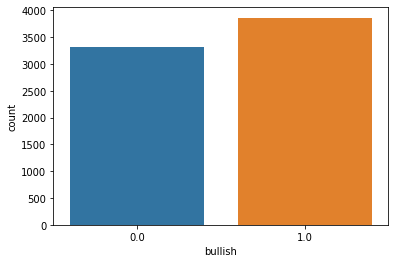

In [22]:
sns.countplot(x='bullish', data=grouped_tweets)

In [23]:
grouped_tweets.dropna(inplace=True)
bullish_groups = grouped_tweets.loc[grouped_tweets.bullish == 1]
bearish_groups = grouped_tweets.loc[grouped_tweets.bullish == 0]

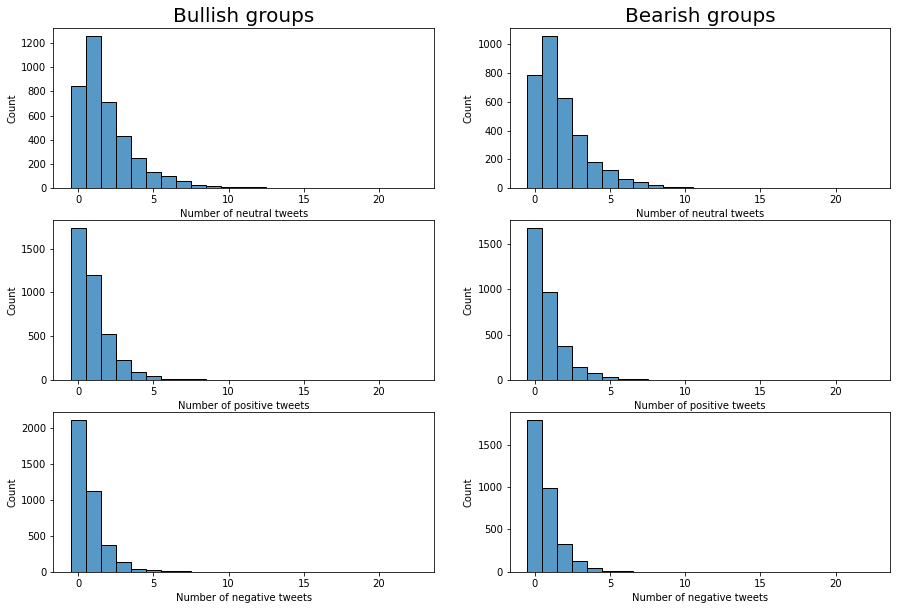

In [24]:
max_tweets = max(grouped_tweets.neutral_tweets.max(), grouped_tweets.positive_tweets.max(),
                 grouped_tweets.negative_tweets.max())

fig, ax = plt.subplots(3, 2, figsize=(15, 10))
ax[0, 0].set_title("Bullish groups", fontsize=20)
ax[0, 1].set_title("Bearish groups", fontsize=20)

# Histogram of number of neutral tweets distribution
sns.histplot(x='neutral_tweets', data=bullish_groups, ax=ax[0, 0], 
             discrete=True, binrange=(0, max_tweets))
sns.histplot(x='neutral_tweets', data=bearish_groups, ax=ax[0, 1], 
             discrete=True, binrange=(0, max_tweets))
ax[0, 0].set_xlabel("Number of neutral tweets")
ax[0, 1].set_xlabel("Number of neutral tweets")

# Histogram of number of positive tweets distribution
sns.histplot(x='positive_tweets', data=bullish_groups, ax=ax[1, 0], 
             discrete=True, binrange=(0, max_tweets))
sns.histplot(x='positive_tweets', data=bearish_groups, ax=ax[1, 1], 
             discrete=True, binrange=(0, max_tweets))
ax[1, 0].set_xlabel("Number of positive tweets")
ax[1, 1].set_xlabel("Number of positive tweets")

# Histogram of number of negative tweets distribution
sns.histplot(x='negative_tweets', data=bullish_groups, ax=ax[2, 0], 
             discrete=True, binrange=(0, max_tweets))
sns.histplot(x='negative_tweets', data=bearish_groups, ax=ax[2, 1], 
             discrete=True, binrange=(0, max_tweets))
ax[2, 0].set_xlabel("Number of negative tweets")
ax[2, 1].set_xlabel("Number of negative tweets")


plt.show()

For both groups, it appears that the distribution of the number of positive, neutral and negative tweets are generally similar. This seems to indicate that our features may not be appropriate for training a classifier. However, since there is not much other features that we can use, we will try to train a classifier using these features for now.

In [25]:
from sklearn.model_selection import train_test_split


features = ['positive_tweets', 'neutral_tweets', 'negative_tweets']
X_train, X_test, y_train, y_test = train_test_split(grouped_tweets[features], 
                                                    grouped_tweets['bullish'],
                                                    test_size=0.2, 
                                                    random_state=42)

Let's train a baseline Random Forest classifier and check its accuracy

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train, y_train)

y_pred = random_forest_classifier.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred) * 100)

Accuracy score:  54.56445993031359


Indeed, the accuracy of the model is only slightly above 50% for a binary classification, which is not much better than a random guess. Let's try to tune the hyperparameters using randomised grid search based on accuracy
<br>
We will try optimising the following hyperparameters:
- `n_estimators`
- `max_depth`
- `max_features`

In [27]:
from sklearn.model_selection import RandomizedSearchCV


params = {
    'n_estimators': np.arange(start=30, stop=110, step=2),
    'max_depth': np.arange(start=4, stop=7, step=1),
    'max_features': [1, 2, 3]
}

clf = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator=clf, param_distributions=params,
                                   n_iter=300, cv=5, n_jobs=-1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=300,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([4, 5, 6]),
                                        'max_features': [1, 2, 3],
                                        'n_estimators': array([ 30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,  54,
        56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,  80,
        82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104, 106,
       108])})

In [28]:
best_clf = random_search.best_estimator_
y_pred = best_clf.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred) * 100)

Accuracy score:  56.37630662020906


We managed to raise the accuracy by about 2% using a randomised grid search. Nonetheless, the accuracy is still too low for any practical usage. Unfortunately, with our current level of knowledge and the nature of the task, it could be hard to strive for a higher accuracy.
<br>
For the timebeing, we will save the 2 models that we have trained: the **SVM Classifier** for the labelling of tweets, and also the **Random Forest Classifier** for the prediction of price movements.

In [29]:
from joblib import dump
dump(svm_classifier, 'svm_classifier.joblib')
dump(vectorizer, 'vectorizer.joblib')
dump(best_clf, 'rand_forest_classifier.joblib')

['rand_forest_classifier.joblib']